In [2]:
pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [10]:
df=pd.read_csv("Real_Combine.csv")

In [11]:
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

In [13]:
df=df.dropna()

In [14]:
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

In [15]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [27]:
def hyper_tune(param):
    model = keras.Sequential()
    for i in range(param.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=param.Int('units_'+str(i),
                                              min_value=12,
                                              max_value=512,
                                              step=32),
                              activation='tanh'))
    model.add(layers.Dense(i, activation='linear'))
    model.compile(
            optimizer=keras.optimizers.Adam(
                param.Choice('learning_rate',[1e-2, 1e-3, 1e-4])),
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])
    return model

In [28]:
tuner = RandomSearch(
    hyper_tune,
    objective='val_mean_absolute_error',
    max_trials=5,
    max_retries_per_trial=3,
    directory='project',
    overwrite=True,
    project_name='Air Quality Index')

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=0)

In [32]:
tuner.search(x_train, y_train,
            epochs=5,
            validation_data=(x_test, y_test))

Trial 5 Complete [00h 00m 05s]
val_mean_absolute_error: 88.72804260253906

Best val_mean_absolute_error So Far: 65.25467681884766
Total elapsed time: 00h 00m 17s
INFO:tensorflow:Oracle triggered exit


In [40]:
import matplotlib.pyplot as plt

best_hps = tuner.get_best_hyperparameters(1)[0]

model = hyper_tune(best_hps)

history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
                    

Epoch 1/5
24/24 [==============================] - 1s 12ms/step - loss: 77.0250 - mean_absolute_error: 77.0250 - val_loss: 65.6375 - val_mean_absolute_error: 65.6375
Epoch 2/5
24/24 [==============================] - 0s 5ms/step - loss: 66.4655 - mean_absolute_error: 66.4655 - val_loss: 66.2779 - val_mean_absolute_error: 66.2779
Epoch 3/5
24/24 [==============================] - 0s 6ms/step - loss: 66.2506 - mean_absolute_error: 66.2506 - val_loss: 65.7716 - val_mean_absolute_error: 65.7716
Epoch 4/5
24/24 [==============================] - 0s 5ms/step - loss: 66.3246 - mean_absolute_error: 66.3246 - val_loss: 65.5873 - val_mean_absolute_error: 65.5873
Epoch 5/5
24/24 [==============================] - 0s 6ms/step - loss: 66.3288 - mean_absolute_error: 66.3288 - val_loss: 65.3290 - val_mean_absolute_error: 65.3290


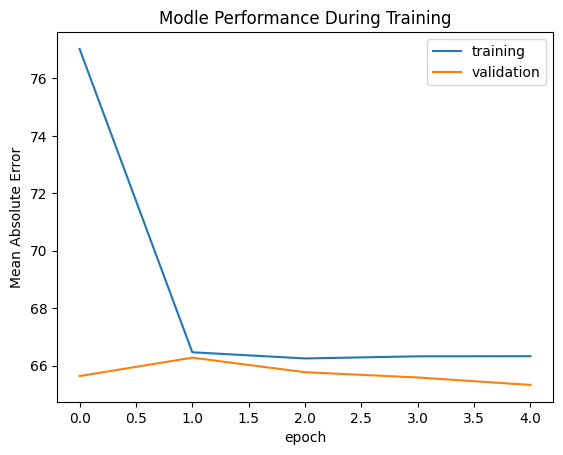

In [43]:
plt.plot(history.history['mean_absolute_error'], label='training')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.title('Modle Performance During Training')
plt.xlabel('epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()